In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = data_per_word * len(words)
timesteps = 50
dimensions = 3 * 44

In [3]:
def get_bone_pos(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    bone_pos = np.zeros([44, 3]) # [cooridinates x fingers]
#     finger_tip = {}
    if 'right' in frame['hands']:
        bone_pos[0, :] = np.array([frame['hands']['right']['yaw'], frame['hands']['right']['roll'], frame['hands']['right']['pitch']])
        bone_pos[1, :] = np.array(frame['hands']['right']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
            bone_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            bone_pos[2 + 5 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['intermediate']['next_joint'])
            bone_pos[2 + 10 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['proximal']['next_joint'])
            bone_pos[2 + 15 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['metacarpal']['next_joint'])
    if 'left' in frame['hands']:
        bone_pos[22, :] = np.array([frame['hands']['left']['yaw'], frame['hands']['left']['roll'], frame['hands']['left']['pitch']])
        bone_pos[23, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
            bone_pos[4 + 20 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            bone_pos[4 + 25 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['intermediate']['next_joint'])
            bone_pos[4 + 30 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['proximal']['next_joint'])
            bone_pos[4 + 35 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['metacarpal']['next_joint'])

    return bone_pos

In [4]:
import json
import pandas as pd
import numpy as np

In [13]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [16]:
pick_frame_every_no = max_frame / 50 + 1

In [18]:
x = np.zeros([data_length, timesteps, dimensions])
y = np.array([])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            bones_pos = get_bone_pos(frame)
            for idx, bone_pos in enumerate(bones_pos):
                x[word_no * data_per_word + data_no, curr_idx, idx * 3: idx * 3 + 3] = bone_pos
            curr_idx += 1

        y = np.append(y, word_no)

In [87]:
x_train = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 / 3])
x_test = np.zeros([data_length / 3, timesteps, dimensions])
y_test = np.zeros([data_length / 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx / 3] = x[idx]
        y_test[idx / 3] = y[idx]
    else:
        x_train[idx - idx / 3] = x[idx]
        y_train[idx - idx / 3] = y[idx]

In [88]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 / 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [89]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [90]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [91]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=500, batch_size=8, shuffle=True)

Train on 342 samples, validate on 171 samples
Epoch 1/500
342/342 [==============================] - 6s 18ms/step - loss: 2.9698 - acc: 0.0351 - val_loss: 2.9466 - val_acc: 0.0585
Epoch 2/500
342/342 [==============================] - 3s 7ms/step - loss: 2.9630 - acc: 0.0380 - val_loss: 2.9433 - val_acc: 0.0760
Epoch 3/500
342/342 [==============================] - 2s 7ms/step - loss: 2.9749 - acc: 0.0409 - val_loss: 2.9451 - val_acc: 0.0526
Epoch 4/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9502 - acc: 0.0351 - val_loss: 2.9253 - val_acc: 0.0643
Epoch 5/500
342/342 [==============================] - 2s 6ms/step - loss: 3.0262 - acc: 0.0439 - val_loss: 2.9423 - val_acc: 0.0526
Epoch 6/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9494 - acc: 0.0380 - val_loss: 2.9450 - val_acc: 0.0526
Epoch 7/500
342/342 [==============================] - 2s 7ms/step - loss: 2.9421 - acc: 0.0468 - val_loss: 2.9469 - val_acc: 0.0526
Epoch 8/500
342/342 [=

Epoch 62/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9365 - acc: 0.0439 - val_loss: 2.9446 - val_acc: 0.0526
Epoch 63/500
342/342 [==============================] - 2s 7ms/step - loss: 2.9377 - acc: 0.0351 - val_loss: 2.9445 - val_acc: 0.0526
Epoch 64/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9384 - acc: 0.0322 - val_loss: 2.9445 - val_acc: 0.0526
Epoch 65/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9379 - acc: 0.0263 - val_loss: 2.9446 - val_acc: 0.0526
Epoch 66/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9374 - acc: 0.0409 - val_loss: 2.9443 - val_acc: 0.0526
Epoch 67/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9374 - acc: 0.0468 - val_loss: 2.9445 - val_acc: 0.0526
Epoch 68/500
342/342 [==============================] - 2s 7ms/step - loss: 2.9380 - acc: 0.0292 - val_loss: 2.9446 - val_acc: 0.0526
Epoch 69/500
342/342 [==============================] - 2s 6ms

Epoch 123/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9277 - acc: 0.0468 - val_loss: 2.9446 - val_acc: 0.0526
Epoch 124/500
342/342 [==============================] - 3s 8ms/step - loss: 2.9282 - acc: 0.0556 - val_loss: 2.9446 - val_acc: 0.0526
Epoch 125/500
342/342 [==============================] - 3s 7ms/step - loss: 2.9443 - acc: 0.0439 - val_loss: 2.9269 - val_acc: 0.0585
Epoch 126/500
342/342 [==============================] - 2s 7ms/step - loss: 2.9504 - acc: 0.0380 - val_loss: 2.9269 - val_acc: 0.0585
Epoch 127/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9364 - acc: 0.0526 - val_loss: 2.9414 - val_acc: 0.0526
Epoch 128/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9223 - acc: 0.0468 - val_loss: 2.8989 - val_acc: 0.1053
Epoch 129/500
342/342 [==============================] - 2s 6ms/step - loss: 3.4696 - acc: 0.0819 - val_loss: 2.9321 - val_acc: 0.0585
Epoch 130/500
342/342 [==============================] 

342/342 [==============================] - 2s 6ms/step - loss: 2.8191 - acc: 0.0789 - val_loss: 2.7776 - val_acc: 0.0819
Epoch 184/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8305 - acc: 0.0760 - val_loss: 2.7755 - val_acc: 0.0877
Epoch 185/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8374 - acc: 0.0497 - val_loss: 2.7700 - val_acc: 0.0936
Epoch 186/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8170 - acc: 0.0760 - val_loss: 2.7711 - val_acc: 0.0877
Epoch 187/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8182 - acc: 0.0731 - val_loss: 2.7827 - val_acc: 0.0877
Epoch 188/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8217 - acc: 0.0643 - val_loss: 2.7784 - val_acc: 0.0877
Epoch 189/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8383 - acc: 0.0731 - val_loss: 2.7807 - val_acc: 0.0936
Epoch 190/500
342/342 [==============================] - 2s 6ms/step 

Epoch 244/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8208 - acc: 0.0731 - val_loss: 2.7784 - val_acc: 0.0760
Epoch 245/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8636 - acc: 0.0731 - val_loss: 2.8036 - val_acc: 0.0819
Epoch 246/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8443 - acc: 0.0819 - val_loss: 2.7787 - val_acc: 0.0819
Epoch 247/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8187 - acc: 0.0819 - val_loss: 2.7784 - val_acc: 0.0877
Epoch 248/500
342/342 [==============================] - 2s 6ms/step - loss: 2.7894 - acc: 0.0848 - val_loss: 2.7755 - val_acc: 0.0760
Epoch 249/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8250 - acc: 0.0965 - val_loss: 2.7733 - val_acc: 0.0760
Epoch 250/500
342/342 [==============================] - 2s 6ms/step - loss: 2.7892 - acc: 0.0848 - val_loss: 2.7804 - val_acc: 0.0760
Epoch 251/500
342/342 [==============================] 

342/342 [==============================] - 2s 6ms/step - loss: 2.8188 - acc: 0.0819 - val_loss: 2.7679 - val_acc: 0.0936
Epoch 305/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8379 - acc: 0.0936 - val_loss: 2.7727 - val_acc: 0.0936
Epoch 306/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8199 - acc: 0.0848 - val_loss: 2.7671 - val_acc: 0.0936
Epoch 307/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8049 - acc: 0.0789 - val_loss: 2.7693 - val_acc: 0.0702
Epoch 308/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8131 - acc: 0.0760 - val_loss: 2.7645 - val_acc: 0.0760
Epoch 309/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8309 - acc: 0.0673 - val_loss: 2.7590 - val_acc: 0.0994
Epoch 310/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8205 - acc: 0.0906 - val_loss: 2.7631 - val_acc: 0.1053
Epoch 311/500
342/342 [==============================] - 2s 6ms/step 

Epoch 365/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8231 - acc: 0.0673 - val_loss: 2.7679 - val_acc: 0.0877
Epoch 366/500
342/342 [==============================] - 2s 6ms/step - loss: 2.8321 - acc: 0.0994 - val_loss: 2.7645 - val_acc: 0.0702
Epoch 367/500
342/342 [==============================] - 3s 7ms/step - loss: 2.8125 - acc: 0.0614 - val_loss: 2.7595 - val_acc: 0.0936
Epoch 368/500
342/342 [==============================] - 2s 7ms/step - loss: 2.8095 - acc: 0.0760 - val_loss: 2.7666 - val_acc: 0.0877
Epoch 369/500
342/342 [==============================] - 2s 7ms/step - loss: 2.7998 - acc: 0.0877 - val_loss: 2.7649 - val_acc: 0.0994
Epoch 370/500
342/342 [==============================] - 2s 7ms/step - loss: 2.8043 - acc: 0.0994 - val_loss: 2.7566 - val_acc: 0.1228
Epoch 371/500
342/342 [==============================] - 2s 6ms/step - loss: 2.7955 - acc: 0.0789 - val_loss: 2.7592 - val_acc: 0.1287
Epoch 372/500
342/342 [==============================] 

342/342 [==============================] - 2s 6ms/step - loss: 2.9364 - acc: 0.0585 - val_loss: 2.9469 - val_acc: 0.0585
Epoch 426/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9452 - acc: 0.0585 - val_loss: 2.9478 - val_acc: 0.0643
Epoch 427/500
342/342 [==============================] - 3s 8ms/step - loss: 2.9261 - acc: 0.0614 - val_loss: 2.9452 - val_acc: 0.0468
Epoch 428/500
342/342 [==============================] - 2s 7ms/step - loss: 2.9530 - acc: 0.0439 - val_loss: 2.9482 - val_acc: 0.0409
Epoch 429/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9358 - acc: 0.0556 - val_loss: 2.9450 - val_acc: 0.0643
Epoch 430/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9364 - acc: 0.0673 - val_loss: 2.9425 - val_acc: 0.0760
Epoch 431/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9488 - acc: 0.0643 - val_loss: 2.9434 - val_acc: 0.0585
Epoch 432/500
342/342 [==============================] - 2s 7ms/step 

Epoch 486/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9333 - acc: 0.0556 - val_loss: 2.9445 - val_acc: 0.0585
Epoch 487/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9271 - acc: 0.0614 - val_loss: 2.9452 - val_acc: 0.0643
Epoch 488/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9319 - acc: 0.0673 - val_loss: 2.9451 - val_acc: 0.0526
Epoch 489/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9304 - acc: 0.0497 - val_loss: 2.9448 - val_acc: 0.0526
Epoch 490/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9379 - acc: 0.0468 - val_loss: 2.9447 - val_acc: 0.0526
Epoch 491/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9254 - acc: 0.0614 - val_loss: 2.9455 - val_acc: 0.0526
Epoch 492/500
342/342 [==============================] - 2s 6ms/step - loss: 2.9222 - acc: 0.0614 - val_loss: 2.9449 - val_acc: 0.0526
Epoch 493/500
342/342 [==============================] 

In [92]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

171/171 [==============================] - 0s 635us/step
('Test score:', 2.9453777988054597)
('Test accuracy:', 0.046783626079559326)


In [93]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


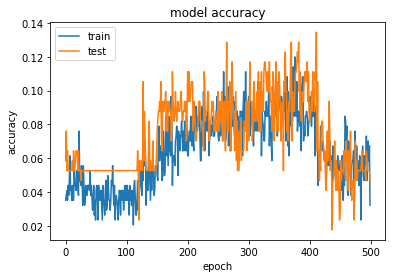

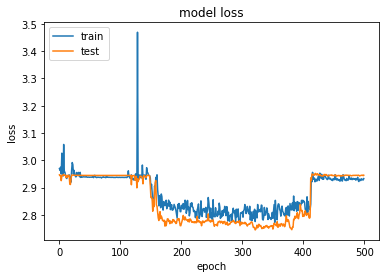

In [94]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()